In [2]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.append('script')
from script import dbconn
pgconn = dbconn.db_connection_psycopg()

In [9]:
raw_df = dbconn.db_read_table_psycopg(pgconn,'xdr_data')

c:\Users\o876\Desktop\User-Analytics-in-telecommunication-industry\script\dbconn.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,pgconn)


In [37]:
# Working on User Overview analysis 
raw_df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [ ]:
# Aggregate the number of xDR sessions per user
sessions_per_user = raw_df.groupby('MSISDN/Number')['Bearer Id'].count()
print(sessions_per_user)

In [ ]:
# Aggregate the session duration per user
session_duration_per_user = raw_df.groupby('MSISDN/Number')['Dur. (ms)'].sum()

# Display the result
print(session_duration_per_user)

In [ ]:
# Aggregate the total download and upload data per user
total_data_per_user = raw_df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum()

# Display the result
print(total_data_per_user)

In [ ]:
# Create a list of application columns
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Aggregate the total data volume per user and application
total_data_per_user_app = raw_df.groupby('MSISDN/Number')[[col + ' DL (Bytes)' for col in applications] + [col + ' UL (Bytes)' for col in applications]].sum()

# Display the result
print(total_data_per_user_app)

In [ ]:
# EDA
# Treat all missing values and outliers in the dataset by replacing by the mean of the corresponding column.
# First Identifying and Treating missing value 
missing_values = raw_df.isna().sum()
print(missing_values)

# Replace missing values with the mean of the column
data = raw_df.fillna(raw_df.mean()) 
# required some code cehckup


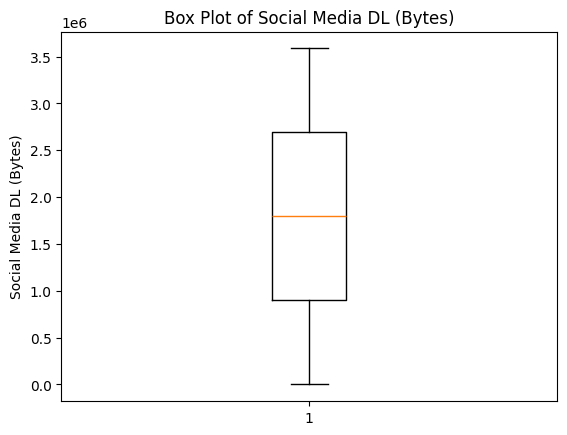

In [48]:
# Visualize the data using box plots (assuming two variables: X and Y)
column_name = 'Social Media DL (Bytes)'
column_data = raw_df[column_name]

plt.boxplot(column_data)
plt.title('Box Plot of ' + column_name)
plt.ylabel(column_name)
plt.show()

In [49]:
# Analyze the basic metrics
raw_df.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,1.490100e+05,150000.000000,150000.000000,1.500000e+05,1.494310e+05,1.489350e+05,1.494290e+05,122172.000000,122189.000000,150000.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500000e+05,1.500000e+05
mean,1.013887e+19,499.188200,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,13300.045927,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,2.893173e+18,288.611834,288.097653,8.103762e+04,2.148809e+10,2.447443e+12,2.241637e+13,619.782739,84.793524,23971.878541,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127639e+07,2.441429e+08
min,6.917538e+18,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,7.349883e+18,250.000000,251.000000,5.744050e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,43.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322201e+07,2.431068e+08
50%,7.349883e+18,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572201e+13,45.000000,5.000000,63.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,1.304243e+19,749.000000,750.000000,1.324302e+05,2.082018e+14,3.368349e+10,8.611970e+13,70.000000,15.000000,19710.750000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657055e+08
max,1.318654e+19,999.000000,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


In [51]:
# Conduct a Non-Graphical Univariate Analysis by computing dispersion parameters for each quantitative variable and provide useful interpretation.
# Difference b/n max and min value in each variable ||  larger range indicates a wider dispersion
column_names = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)']
for column_name in column_names:
    column_data = raw_df[column_name]
    data_range = column_data.max() - column_data.min()
    print("Range of", column_name, ":", data_range)

Range of Avg RTT DL (ms) : 96923.0
Range of Avg RTT UL (ms) : 7120.0


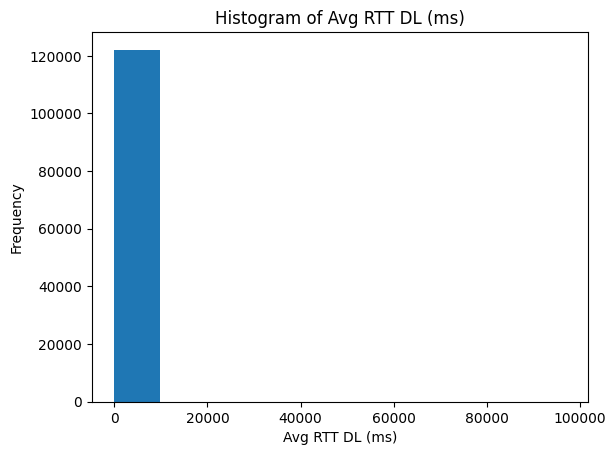

In [52]:
# Conduct a Graphical Univariate Analysis by identifying the most suitable plotting options for each variable and interpret your findings.

column_name = 'Avg RTT DL (ms)'
column_data = raw_df[column_name]

plt.hist(column_data, bins=10)
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)
plt.show()

In [59]:
# Variable transformations – segment the users into top five decile classes based on the total duration for all sessions and compute the total data (DL+UL) per decile class. 

# Calculate the total duration for all sessions for each user
user_total_duration = raw_df.groupby('MSISDN/Number')['Dur. (ms)'].sum()

# Segment users into decile classes
user_deciles = pd.qcut(user_total_duration, q=10, labels=False, duplicates='drop')

# Compute the total data (DL+UL) per decile class
data_per_decile = raw_df.groupby(user_deciles)[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index()

In [65]:
# Correlation Analysis – compute a correlation matrix for the following variables and interpret your findings: Social Media data, Google data, Email data, Youtube data, Netflix data, Gaming data, Other data 
# Select the columns for correlation analysis
columns = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

# Create a subset dataframe with the selected columns
subset_df = raw_df[columns]

# Compute the correlation matrix
correlation_matrix = subset_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                         Social Media DL (Bytes)  Social Media UL (Bytes)  \
Social Media DL (Bytes)                 1.000000                -0.000555   
Social Media UL (Bytes)                -0.000555                 1.000000   
Google DL (Bytes)                      -0.001954                 0.003542   
Google UL (Bytes)                       0.000186                 0.001085   
Email DL (Bytes)                        0.004745                 0.004823   
Email UL (Bytes)                       -0.002518                -0.001427   
Youtube DL (Bytes)                     -0.001389                -0.001786   
Youtube UL (Bytes)                      0.002345                -0.002368   
Netflix DL (Bytes)                     -0.001817                -0.000772   
Netflix UL (Bytes)                      0.003457                -0.002493   
Gaming DL (Bytes)                       0.001018                 0.000210   
Gaming UL (Bytes)                       0.003095                 0.000844   